# DATA SCIENCE SKILL DEMAND ANALYSIS

## 1. Business understanding

The purpose of this project is to create data-informed action plans to improve existing courses/programs. The goal for this reseach project is to better understand the current trend of analytics skill demands in the job market. 

## 2. Data Understanding

This program searches "Analyst" job posting data within Columbus from Indeed website. In future, this program can also be used to analyze for other job titles from Indeed website for further usage.

Skills this reseach will practice are:
- Data scrapping from Indeed website with keyword "Analyst" constrain
- Data cleaning and analysis with pandas
- Data visualization with matplotlib and seaborn
- Result confidence interval with bootstrapping

## 3. Data Preparation

### 3.1. Web Scraping using Selenium

A Web Scraper was built to pull all the relevant job information of "analyst" within the Columbus area from the job portal in Indeed.com. Pulled data indicates fields of Title, Company, Location, Link, Salary, Date, and Description. The scraper will automatically save its result to the feather file where its file name is the current date to the source folder. The scraper needs to run in every 15 days since the maximum result age is 15 days in Indeed for new job postings. These feather files in the source folder will then be used to analyze the trend of analytics computing skills. This program was built using selenium-python.


In [26]:
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
import pickle
import re

# Show single source file size
sample = pd.read_feather("/Users/huilingchen/Documents/GitHub/indeed_web_scraper/source/11_12_2020")
sample.shape

(171, 7)

### 3.2. Combine all feather file from source folder

In [27]:
import os
import glob

dir_name = "/Users/huilingchen/Documents/GitHub/indeed_web_scraper/source"
os.chdir(dir_name)

all_filenames = [i for i in glob.glob('*')]
combined_source = pd.concat([pd.read_feather(f) for f in all_filenames], ignore_index=True)
combined_source = combined_source[combined_source.Description != 'None']
combined_source.tail(5)


,Title,Company,Location,Link,Salary,Date,Description
1228,Revenue Cycle (IT) - Billing Interface Analyst,Radiology Partners,"Columbus, OH",https://www.indeed.com/company/Radiology-Partn...,None,11/30/2020,PRACTICE OVERVIEW\nRadiology Partners is the l...
1229,Senior Professional Programmer Analyst,Gainwell Technologies,"Dublin, OH 43016",https://www.indeed.com/rc/clk?jk=6a1105634377a...,None,11/30/2020,Job Description:\nEssential Job Functions\nCod...
1230,Remote - Contract & Billing Analyst I - US Cit...,Catapult,"Columbus, OH",https://www.indeed.com/company/Catapult/jobs/R...,None,11/30/2020,Candidate is required to be a U.S. Citizen\nEx...
1231,Business Analyst - IT Data Warehouse,Radiology Partners,"Columbus, OH",https://www.indeed.com/company/Radiology-Partn...,None,11/30/2020,PRACTICE OVERVIEW\nRadiology Partners is the l...
1232,Programmer Analyst Sr (Datastage Developer),Huntington Bank,"Columbus, OH",https://www.indeed.com/rc/clk?jk=43628ce3ba4b7...,None,11/30/2020,Description\nThe Datastage Developer will be r...


### 3.3. Handling duplicate data

In [28]:
# Remove duplicate rows
combined_source = combined_source[combined_source.Description != 'None']
combined_source=combined_source.drop_duplicates(subset=['Title', 'Company', 'Date'], keep='last')
combined_source.shape

(1152, 7)

## 4. Data Modeling

### 4.1. Specify tool usage indicator

In [29]:
df_indicator = pd.DataFrame()
df_indicator['SAS'] = np.where(combined_source['Description'].str.contains('SAS'), True, False)
df_indicator['python'] = np.where(combined_source['Description'].str.contains('python', flags=re.IGNORECASE),True, False)
df_indicator['SQL'] = np.where(combined_source['Description'].str.contains('sql', flags=re.IGNORECASE),True, False)
df_indicator['R'] = np.where(combined_source['Description'].str.contains(' R | R,|,R ', flags=re.IGNORECASE),True, False)
df_indicator['excel'] = np.where(combined_source['Description'].str.contains('excel', flags=re.IGNORECASE),True, False)
df_indicator.tail()

,SAS,python,SQL,R,excel
1147,False,False,False,False,True
1148,False,False,False,False,False
1149,False,False,False,False,True
1150,False,False,False,False,False
1151,False,False,True,False,False


### 4.2. Compose tool occurrence percentage table

In [30]:
percentage = pd.DataFrame()
percentage['SAS'] = df_indicator['SAS'].value_counts(normalize=True) * 100 
percentage['Python'] = df_indicator['python'].value_counts(normalize=True) * 100 
percentage['Excel'] = df_indicator['excel'].value_counts(normalize=True) * 100 
percentage['R'] = df_indicator['R'].value_counts(normalize=True) * 100 
percentage['SQL'] = df_indicator['SQL'].value_counts(normalize=True) * 100 
os.chdir("/Users/huilingchen/Documents/GitHub/indeed_web_scraper")
percentage.index = ['False', 'True'] 
percentage

,SAS,Python,Excel,R,SQL
False,95.052083,92.447917,38.020833,96.006944,78.211806
True,4.947917,7.552083,61.979167,3.993056,21.788194


### 4.3. Transpose percentage table

In [31]:
transposed=percentage.T
new_percentage=transposed.reset_index()
new_percentage=new_percentage.sort_values(by=['True'], ascending=False)
new_percentage
#list(new_percentage.columns)

,index,False,True
2,Excel,38.020833,61.979167
4,SQL,78.211806,21.788194
1,Python,92.447917,7.552083
0,SAS,95.052083,4.947917
3,R,96.006944,3.993056


### 4.4. Use barplot to show the result of tool usage

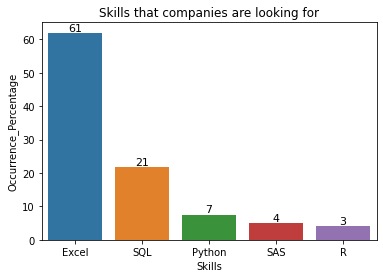

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.barplot(x = 'index', y = 'True', data = new_percentage)
plt.xlabel("Skills")
plt.ylabel("Occurrence_Percentage")
plt.title("Skills that companies are looking for")
ax =plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(), '%d' % int(p.get_height()), fontsize=11, color='black', ha='center', va='bottom')


### Observation:

1. Excel is highly demanded skill for analyst jobs. 
2. Looks like R language usage for analyst jobs in Columbus area job market is not in high demand, its even lesser than SAS.
3. This result is from keyword "Analyst" and "Columbus", when more narrow keyword applies the result could improve.

## 5. Evaluation

### 5.1. Define a function to calculate the "true" percentage from a data set.

In [33]:
def get_percentage(data):
    n = len(data)
    res_t = 0
    res_f = 0
    for i in range(n):
        if data[i]:
            res_t += 1
    return res_t/n

In [34]:
# test get percentage
get_percentage(df_indicator["SAS"])

0.049479166666666664

### 5.2. Define a function to get bootstrap replicates

In [35]:
def draw_bs_replicates(data, func, size):
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_sample = np.random.choice(data, size=len(data))
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

### 5.3. Make bootstrap replicates and calculate confidence interval

In [36]:
bs_replicates = {}
conf_interval = {}

for col_name in df_indicator.columns.values:
    bs_replicates[col_name] = draw_bs_replicates(df_indicator[col_name], get_percentage, 300)
    conf_interval[col_name] = np.percentile(bs_replicates[col_name],[5,95])

### 5.4. Show tool usage percentage error 

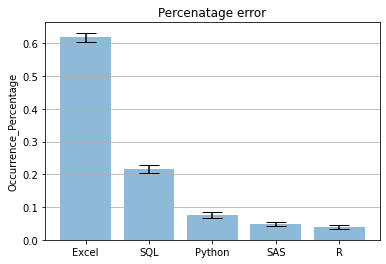

In [37]:
tools = ['Excel', 'SQL', 'Python', 'SAS', 'R']
x_pos = np.arange(len(tools))
means = [np.mean(bs_replicates["excel"]),np.mean(bs_replicates["SQL"]),np.mean(bs_replicates["python"]),np.mean(bs_replicates["SAS"]),np.mean(bs_replicates["R"])]                                                                                                                                        
error = [np.std(bs_replicates["excel"]),np.std(bs_replicates["SQL"]),np.std(bs_replicates["python"]),np.std(bs_replicates["SAS"]),np.std(bs_replicates["R"])]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Occurrence_Percentage')
ax.set_xticks(x_pos)
ax.set_xticklabels(tools)
ax.set_title('Percenatage error')
ax.yaxis.grid(True)


### 5.5. Calculate the metrics for each data set and plot the "true" percentage pdf.

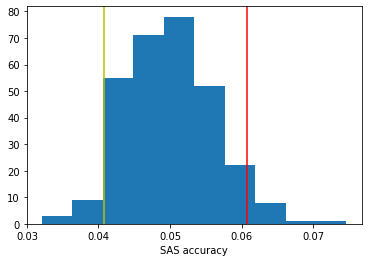

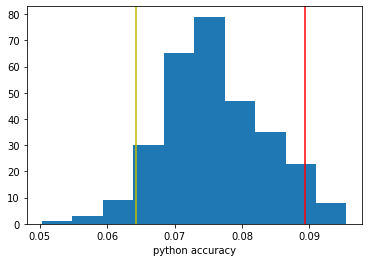

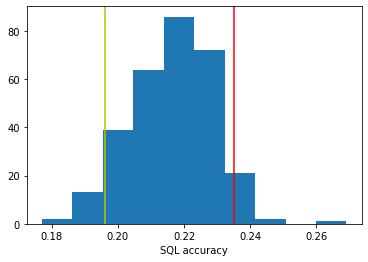

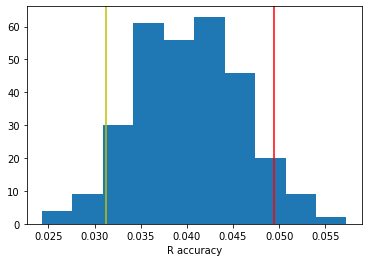

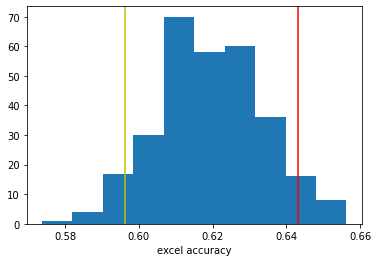

In [13]:
for i in range(5):
    plt.hist(bs_replicates[df_indicator.columns.values[i]])

    plt.axvline(x=np.percentile(bs_replicates[df_indicator.columns.values[i]],[5]), ymin=0, ymax=1,label='5th percentile',c='y')
    plt.axvline(x=np.percentile(bs_replicates[df_indicator.columns.values[i]],[95]), ymin=0, ymax=1,label='95th percentile',c='r')

    plt.xlabel(df_indicator.columns.values[i] + " accuracy")
    plt.show()

### 5.5. Get the confidence interval

In [14]:
conf_interval

{'SAS': array([0.04079861, 0.06080729]),
 'python': array([0.06423611, 0.08940972]),
 'SQL': array([0.19613715, 0.23524306]),
 'R': array([0.03125   , 0.04947917]),
 'excel': array([0.59635417, 0.64322917])}

## 6. Conclusion

There is a high demand for Excel with analysts jobs. SQL is also in a relatively high demand but not as much as Excel. Python, SAS, and R have lower demand. As shown in result SAS have slightly but higher demand than R, this is a indicates SAS skill demand for businesses in Columbus area. I believe that the demand for SAS will keep existing for a certain time.